In [2]:
import numpy as np
import pandas as pd 
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import pickle

import warnings
warnings.filterwarnings("ignore")

# Plan 
## 1. Préparation des fonctions de modélisation
## 2. Préparation sur un échantillon de données
## 3. Entrainement des modèles et visualisation résultats
## 4. Selection du/des modèles et entrainement sur l'ensemble des données
## 5. Résultats et conclusion

# 1. Préparation des fonctions de modélisation

In [3]:
#Création de la fonction d'entrainement d'un modèle
def training_model(model):
    """Création d'une fonction qui entraine un modèle donnée et qui renvoie différentes informations :
    - Affiche le score après une cross validation
    - Renvoi les prédictions du modèle
    - Renvoi la durée d'entrainement du modèle 
    - Renvoi le score (R²)
    - Renvoi le modèle préentrainé
    return : (y_pred, training_time, scoring,  model)
    """
    #Entrainement du modèle sur 5 splits par cross validation :
    scores = cross_val_score(estimator=model, X = X_train, y = y_train,
                             cv=5,scoring="r2") #Utilisons le score r2 pour regarder chaque split 

    #Temps début d'entrainement :
    start_time = time.time()
    #Entrainement :
    model.fit(X_train,y_train)
    #Temps fin entrainement
    end_time = time.time()
    # Durée d'entrainement en minute :
    training_time = round((end_time - start_time)/60,2)
    
    #récupération des prédictions du modèle : 
    y_pred = model.predict(X_test)
    
    
    #Affichage du nom du modèle entrainé : 
    print("\n",type(model).__name__,) 
    print(f"\nAffichage du score sur les {len(scores)} splits :")
    print(f"{[i for i in scores.round(2)]}")
    
    return (y_pred, training_time, model)

In [4]:
def mesure(prediction, model):
    """
    Renvoi un dataframe contenant les valeurs des différentes
    metrics enregistrées à partir des prédicions d'un modèle:
    RMSLE,RMSE, MSE,MAE & R²
    return : Dataframe
    """


    # Calcul des différentes metrics rmsle,rmse, mae,R²
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mse = mean_squared_error(y_test, prediction, squared=True)
    mae = median_absolute_error(y_test, prediction)
    r2 = r2_score(y_test, prediction)
    

    # Récupération de l'ensemble des metrics
    all_metric = [rmse, mse, mae, r2]
    index_metric = ["RMSE", "MSE", "MAE", "R²"]

    metric_series = pd.Series(all_metric, name=str(model), index=index_metric)

    return pd.DataFrame(metric_series).T

In [5]:
def visualisation_pred_real(model):
    """
    Fonction qui récupère les prédictions d'un modèle et affiche un graphique en comparant avec les valeurs réelles
    les valeurs réelles sont sur l'axe des x et les valeurs prédites sont sur l'axe des y.
    La ligne rouge en pointillés représente une correspondance parfaite entre les valeurs réelles et prédites. 
    Dans un modèle parfait, tous les points se situeraient le long de cette ligne.
    return : scatterplot
    """
    # Supposons que y_test contient les vraies valeurs et y_pred contient les valeurs prédites par votre modèle
    y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 4))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5) #scatterplot avec les vraies valeurs en x et les valeurs prédites en y

    # Ajouter une ligne diagonale pour indiquer une correspondance parfaite entre les valeurs réelles et prédites
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    # Label et  titre
    plt.title('Scatter Plot des Valeurs Réelles vs. Prédites')
    plt.xlabel('Valeurs Réelles')
    plt.ylabel('Valeurs Prédites')
    plt.show()


In [6]:
def graph_time(dictionnary_time):
    df_time = pd.DataFrame.from_dict(dictionnary_time, orient = "index", columns=["Duree d'entrainement"])
    plt.figure(figsize=(16,4))
    plt.grid()
    ax = sns.barplot(x = df_time.index, y = df_time.columns[0], data = df_time)
    ax.set_xticklabels(labels = df_time.index, rotation = 45)
    plt.xlabel("Modèles")
    plt.title("Durée d'entrainement des différents modèles (en minutes)")
    plt.show()

In [7]:
def graphic_score(dictionnary_metric):
    """ fonction qui renvoie directement un graphique contenant les scores mesurés des performances d'un modèle"""
    
    #Transformation du dictionnaire des metrics en un dataframe complet :
    metric_df = pd.concat(dictionnary_metric.values(), axis = 1)
    # Réinitialisation d'abord de l'index pour convertir l'index en colonne
    metric_df_reset = metric_df.reset_index()

    # Ensuite, ON utilise melt avec le nouvel index comme id_vars
    metric_df_melt = metric_df_reset.melt(id_vars="index", var_name="Model", value_name="Score")
    
    plt.figure(figsize=(10,6))
    plt.grid()
    sns.barplot(data=metric_df_melt, x="index", y="Score", hue="Model")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Comparaison des scores des modèles')
    plt.show()


## 2. Préparation sur un échantillon de données :

##### Travaillons sur une fraction du jeu de données (1%)

In [8]:
data = pd.read_csv("/kaggle/input/playground-series-s4e5/train.csv")
df = data.sample(frac = 1/1000, random_state = 42)
df.shape

(1118, 22)

In [9]:
X, y = df.drop(["id",'FloodProbability'], axis = 1), df['FloodProbability']
identifiant = df["id"]
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [10]:
#Création des dictionnaires qui contiendront différentes informations :
dict_model = {} #contiendra les modèles préentrainés
dict_time = {} #contiendra les durées d'entrainement
dict_pred =  {} #contiendra les prédictions
dict_scoring = {} #contiendra les différents scores sur le test set (R²)
dict_metric = {} #contiendra les différentes metrics


In [11]:
all_models = [DummyRegressor(strategy="mean"), 
              LinearRegression(), 
              Ridge(), Lasso(), ElasticNet(),
              RandomForestRegressor(), AdaBoostRegressor(), XGBRegressor()]

## 3. Entrainement des modèles et visualisation des résultats 

In [12]:
#Création d'une boucle qui parcours l'ensemble des modèles selectionnés

for temp_model in all_models:
    #récupérer le nom du modèle : 
    nom_model = type(temp_model).__name__
    
    pred, timing, model = training_model(temp_model) #récupération des prédictions, temps et du modèle 
    
    dict_pred[nom_model] = pred #récupération des prédictions
    dict_time[nom_model] = timing #récupération du temps d'entrainement
#     dict_scoring[nom_model] = scoring #récupération des scores R²
    dict_model[nom_model] = model #récupération du modèle préentrainé
    
    # Pour les metrics :
    dict_metric[nom_model] = mesure(pred, nom_model) #ajout des metrics de notre fonction (MAE,RMSE,MSE,R2)
    dict_metric[nom_model] = dict_metric[nom_model].T #inversion colonne/index pour faciliter la lecture


 DummyRegressor

Affichage du score sur les 5 splits :
[-0.01, -0.02, -0.01, -0.0, -0.01]

 LinearRegression

Affichage du score sur les 5 splits :
[0.84, 0.77, 0.85, 0.85, 0.85]

 Ridge

Affichage du score sur les 5 splits :
[0.84, 0.77, 0.85, 0.85, 0.85]

 Lasso

Affichage du score sur les 5 splits :
[-0.01, -0.02, -0.01, -0.0, -0.01]

 ElasticNet

Affichage du score sur les 5 splits :
[-0.01, -0.02, -0.01, -0.0, -0.01]

 RandomForestRegressor

Affichage du score sur les 5 splits :
[0.47, 0.4, 0.42, 0.48, 0.48]

 AdaBoostRegressor

Affichage du score sur les 5 splits :
[0.41, 0.38, 0.36, 0.38, 0.42]

 XGBRegressor

Affichage du score sur les 5 splits :
[0.57, 0.41, 0.51, 0.49, 0.55]


#### Rq: 
- Comme l'évaluation final de ce projet se fait avec le r2, alors nous avons utiliser ici le r2 pour évaluer le score du cross_val_score 
- Sur très peu de données, La régression linéaire et Ridge sont les modèles ayant les meilleurs valeurs sur tous le dataset


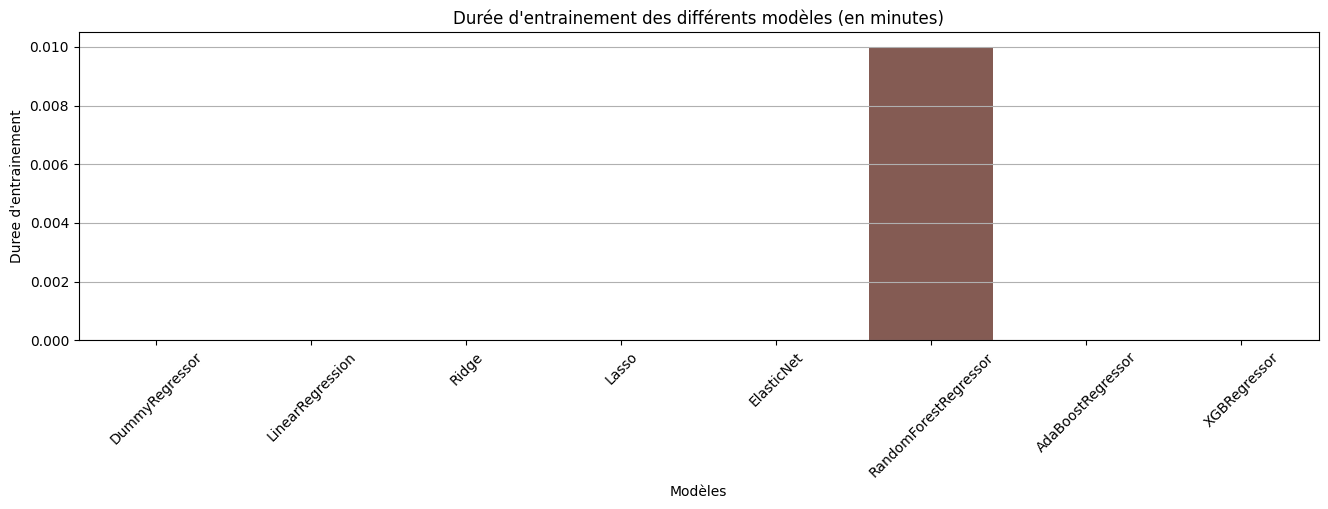

In [13]:
graph_time(dict_time)

Tous les modèles exceptés RandomForest ont des temps d'exécution très brève

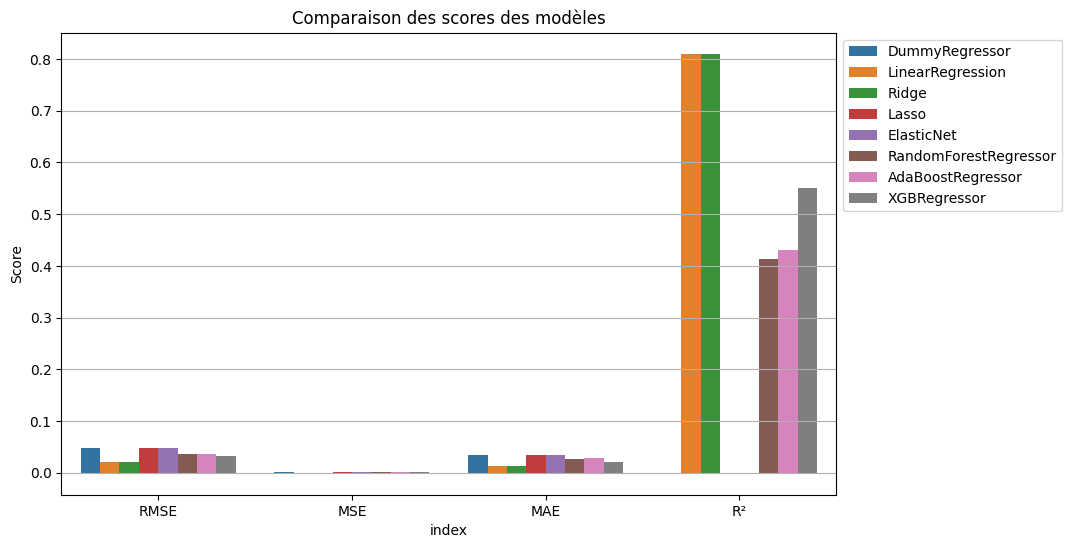

In [14]:
graphic_score(dict_metric)

- Au niveau de la RMSE comme la MSE, tous les modèles ont de meilleurs résultats que le DummyRegressor (valeurs inférieures)
- Pour le R², ridge et la régression linéaire sont les deux meilleurs modèles

DummyRegressor


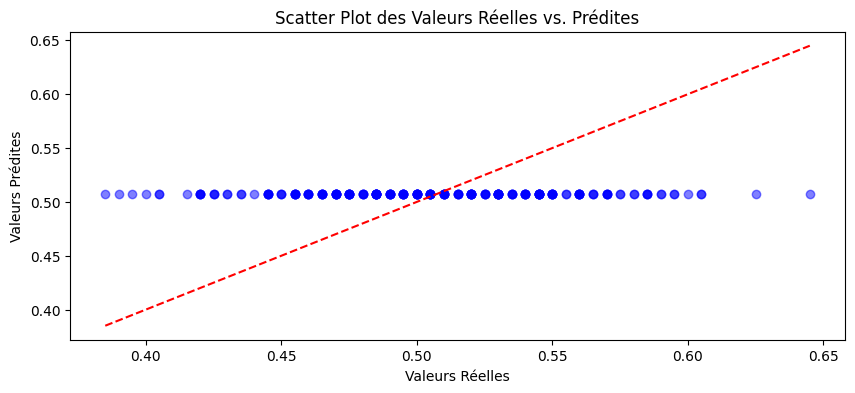

LinearRegression


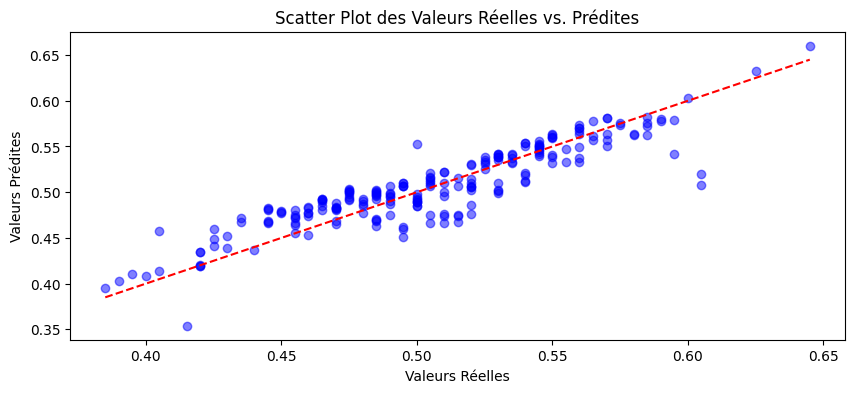

Ridge


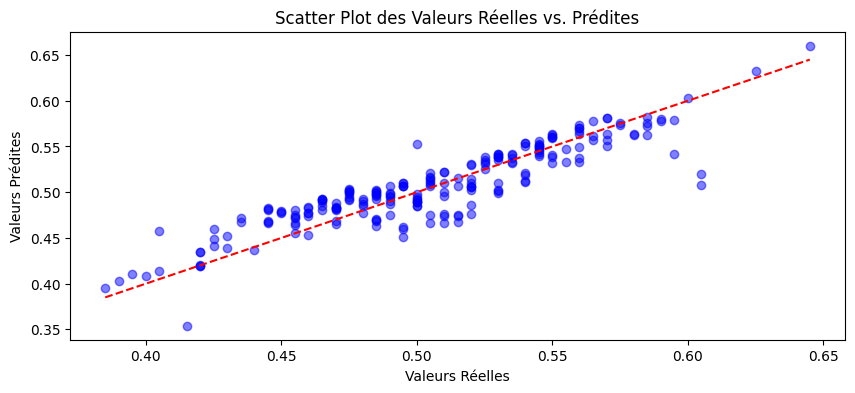

Lasso


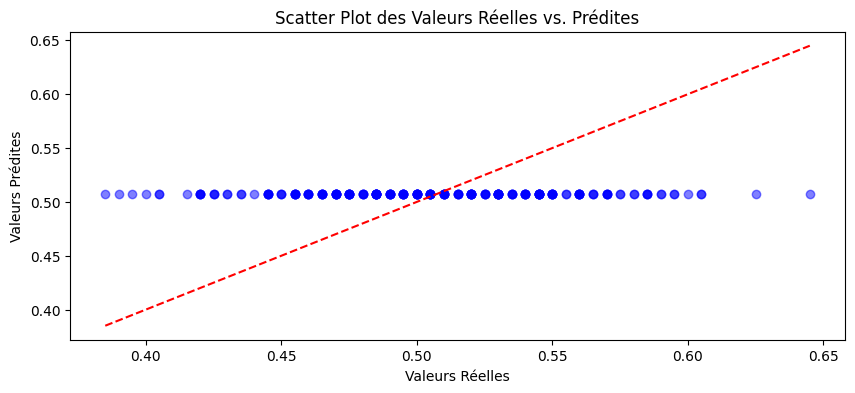

ElasticNet


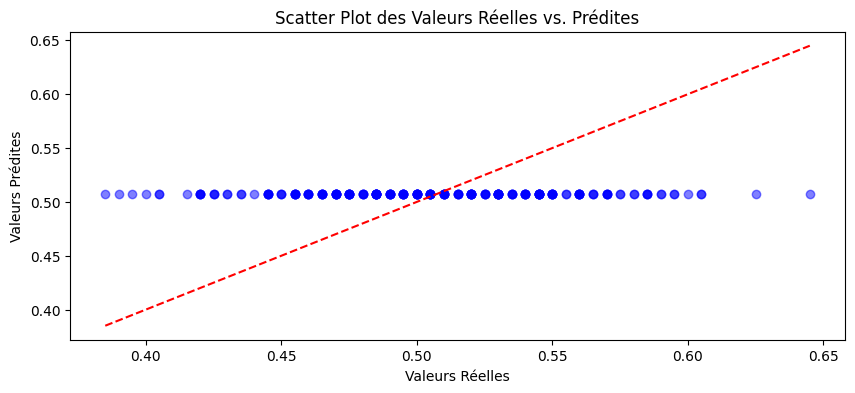

RandomForestRegressor


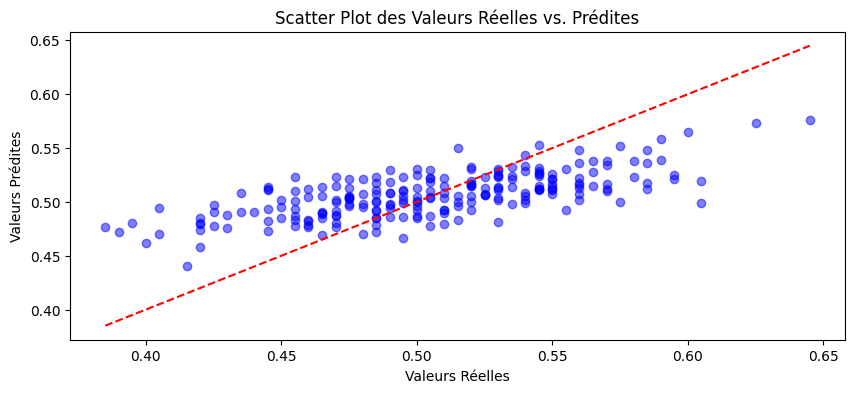

AdaBoostRegressor


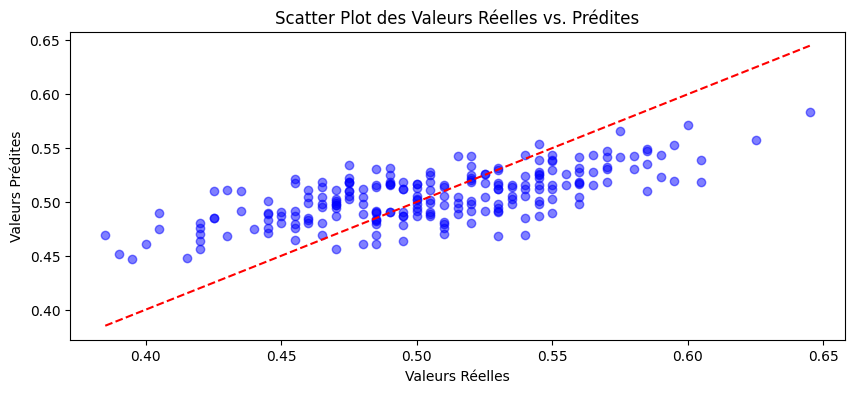

XGBRegressor


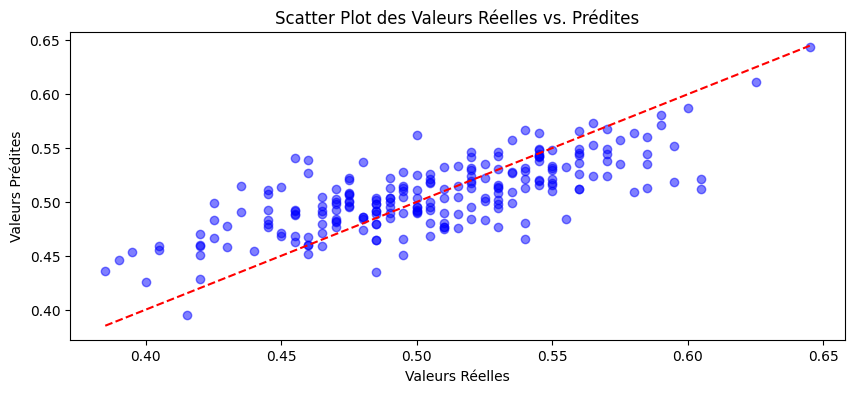

In [15]:
for i in dict_model:
    print(i)
    visualisation_pred_real(dict_model[i])


- Confirmation ici des prédictions de ridge et LinearRegression avec beaucoup de prédictions proche de la droite oblique (= bonnes prédiction)
- Nous allons entrainer ces 2 modèles sur l'ensemble du jeu de données et voir ce que cela donne

## 4. Entrainement du/des modèles selectionnés sur l'ensemble du jeu de données 


In [16]:
data = pd.read_csv("/kaggle/input/playground-series-s4e5/train.csv")
df = data
df.shape


(1117957, 22)

In [17]:
X, y = df.drop('FloodProbability', axis = 1), df['FloodProbability']
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [18]:
selected_model = [LinearRegression(),  Ridge() ]

#Création des dictionnaires qui contiendront différentes informations :
dict_model = {} #contiendra les modèles préentrainés
dict_time = {} #contiendra les durées d'entrainement
dict_pred =  {} #contiendra les prédictions
dict_scoring = {} #contiendra les différents scores sur le test set (R²)
dict_metric = {} #contiendra les différentes metrics

In [19]:
#Création d'une boucle qui parcours l'ensemble des modèles selectionnés

for temp_model in selected_model:
    #récupérer le nom du modèle : 
    nom_model = type(temp_model).__name__
    
    pred, timing, model = training_model(temp_model) #récupération des prédictions, temps et du modèle 
    
    dict_pred[nom_model] = pred #récupération des prédictions
    dict_time[nom_model] = timing #récupération du temps d'entrainement
#     dict_scoring[nom_model] = scoring #récupération des scores R²
    dict_model[nom_model] = model #récupération du modèle préentrainé
    
    # Pour les metrics :
    dict_metric[nom_model] = mesure(pred, nom_model) #ajout des metrics de notre fonction (MAE,RMSE,MSE,R2)
    dict_metric[nom_model] = dict_metric[nom_model].T #inversion colonne/index pour faciliter la lecture


 LinearRegression

Affichage du score sur les 5 splits :
[0.84, 0.85, 0.85, 0.84, 0.85]

 Ridge

Affichage du score sur les 5 splits :
[0.84, 0.85, 0.85, 0.84, 0.85]


## 5. Résultats et conclusion : 

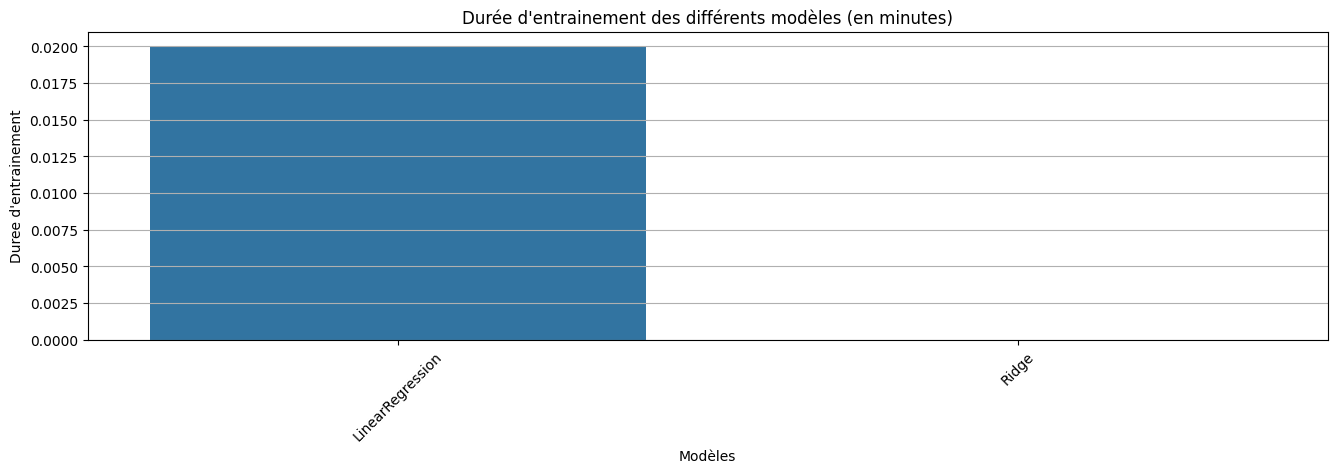

In [20]:
graph_time(dict_time)

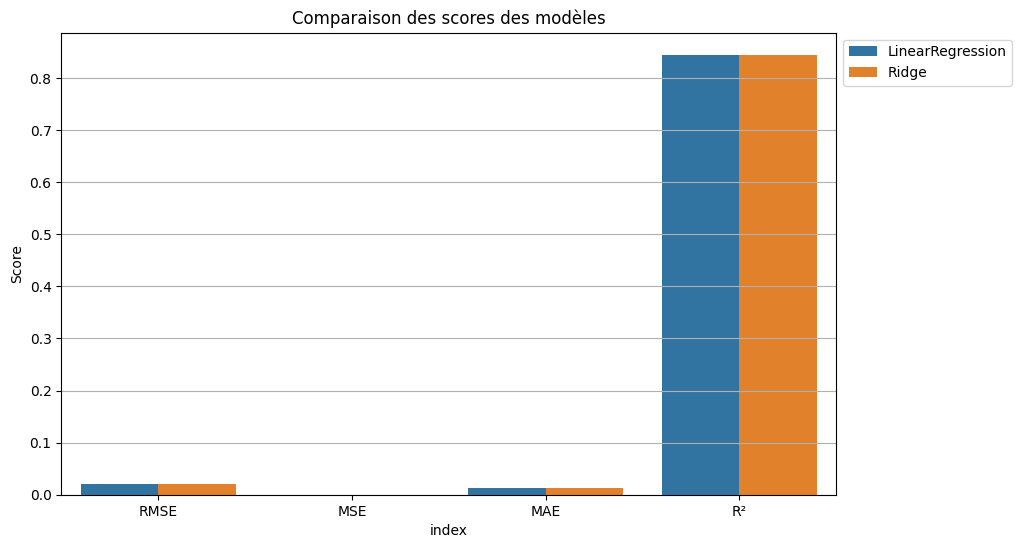

In [24]:
graphic_score(dict_metric)

LinearRegression


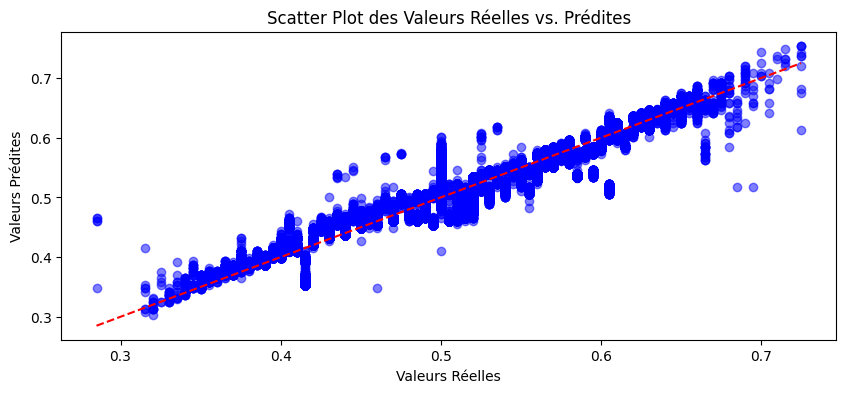

Ridge


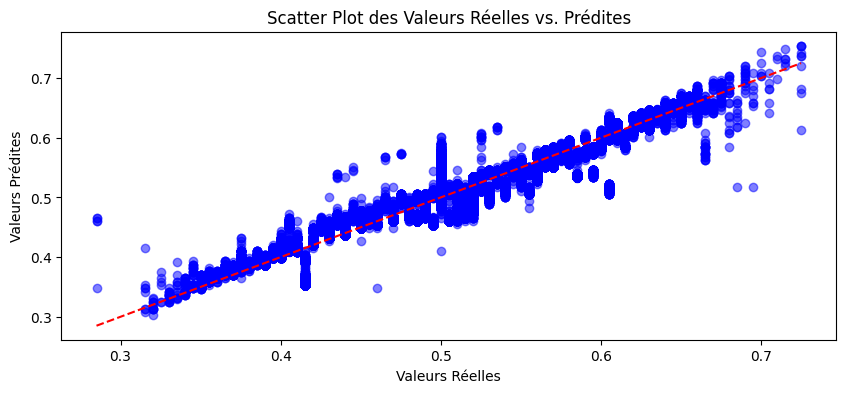

[(None, None), (None, None)]

In [25]:
[(print(type(i).__name__), visualisation_pred_real(i)) for i in  selected_model]


#### Les résultats montrent que les deux modèles sont quasi identique en terme de performance, légère avantage au modèle Ridge qui possède un temps d'exécution plus faible.

## Enregistrement des modèles pré-entrainés et soumission à Kaggle
* Nous allons enregistrer les deux modèles que nous avons préentrainé et les soumettre

In [26]:
new_data = pd.read_csv("/kaggle/input/playground-series-s4e5/test.csv")


In [27]:
new_data.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5


In [28]:
X_train.columns

Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')

In [29]:
def new_prediction(model, data):
    #Récupération des mêmes features que celles utilisés pour l'entrainement des modèles
    columns = model.feature_names_in_
    #Récupération de l'id du jeu de données
    id_data = data["id"]
    #Préparation du dataframe à tester :
    X = data[columns]
    #Récupération des prédictions
    prediction = model.predict(X)
    
    #Transformation des prédictions en dataframe avec l'id en index
    prediction_df = pd.DataFrame(prediction, columns = ["FloodProbability"], index = id_data)
    return prediction_df

In [30]:
#Mettons les modèles selectionnés dans une liste
models = [i for i in dict_model.values()]
models

[LinearRegression(), Ridge()]

In [31]:
### Ridge :
ridge_prediction = new_prediction(models[0], new_data)
### LinearRegression : 
Linear_prediction = new_prediction(models[1], new_data)


In [32]:
 #Aperçu des prédictions pour les deux dataframes : 
pd.concat([ridge_prediction.head(), Linear_prediction.head()], axis = 1)

,FloodProbability,FloodProbability
id,,
1117957,0.573614,0.573614
1117958,0.455272,0.455272
1117959,0.454753,0.454753
1117960,0.466180,0.466180
1117961,0.466086,0.466086


### Note : 
- Sur kaggle, la proposition de soumission du fichier montre un résultat de prédiction avec un arrondie à un chiffre après la virgule.
- Donc si necessaire, nous utiliserons plutôt les dataframe du dessous

In [33]:
ridge_prediction_round = ridge_prediction.apply(lambda x : round(x,2))
Linear_prediction_round = Linear_prediction.apply(lambda x : round(x,2))
pd.concat([ridge_prediction_round.head(), Linear_prediction_round.head()], axis = 1)

,FloodProbability,FloodProbability
id,,
1117957,0.57,0.57
1117958,0.46,0.46
1117959,0.45,0.45
1117960,0.47,0.47
1117961,0.47,0.47


## Enregistrement des dataframes


In [34]:
#Sans arrondis 
ridge_prediction.to_csv("ridge_prediction.csv", )
Linear_prediction.to_csv("Linear_prediction.csv",)
#Avec  :
ridge_prediction_round.to_csv("ridge_prediction_round.csv", )
Linear_prediction_round.to_csv("Linear_prediction_round.csv", )


In [35]:
ridge_pred = pd.read_csv('/kaggle/working/ridge_prediction.csv')
linear_pred_round = pd.read_csv('/kaggle/working/Linear_prediction_round.csv')
ridge_pred_round = pd.read_csv('/kaggle/working/ridge_prediction_round.csv')
linear_pred = pd.read_csv('/kaggle/working/Linear_prediction.csv')

In [36]:
pd.concat([ridge_pred, linear_pred,ridge_pred_round,linear_pred_round], axis = 1)

,id,FloodProbability,id,FloodProbability,id,FloodProbability,id,FloodProbability
0,1117957,0.573614,1117957,0.573614,1117957,0.57,1117957,0.57
1,1117958,0.455272,1117958,0.455272,1117958,0.46,1117958,0.46
2,1117959,0.454753,1117959,0.454753,1117959,0.45,1117959,0.45
3,1117960,0.466180,1117960,0.466180,1117960,0.47,1117960,0.47
4,1117961,0.466086,1117961,0.466086,1117961,0.47,1117961,0.47
...,...,...,...,...,...,...,...,...
745300,1863257,0.477203,1863257,0.477203,1863257,0.48,1863257,0.48
745301,1863258,0.449383,1863258,0.449383,1863258,0.45,1863258,0.45
745302,1863259,0.624315,1863259,0.624315,1863259,0.62,1863259,0.62
745303,1863260,0.550936,1863260,0.550936,1863260,0.55,1863260,0.55
